x shape is (100, 100)


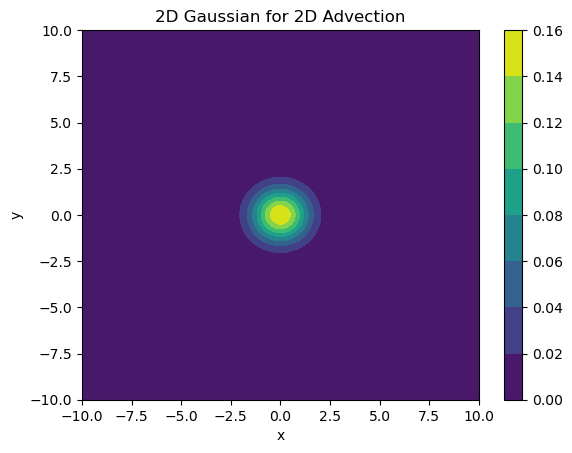

10000
Epoch: 10/100, Loss: 3.349278813402634e-06
Epoch: 20/100, Loss: 1.2856571629527025e-06
Epoch: 30/100, Loss: 9.078657114969246e-08
Epoch: 40/100, Loss: 9.59435340064374e-08
Epoch: 50/100, Loss: 1.2734869869746035e-07
Epoch: 60/100, Loss: 1.7959156650704244e-07
Epoch: 70/100, Loss: 6.995253443164984e-08
Epoch: 80/100, Loss: 2.0135111356012203e-08
Epoch: 90/100, Loss: 1.7639042937389604e-07
Epoch: 100/100, Loss: 3.279362772445893e-07


In [232]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Define the parameters
mean = [0, 1]
cov = [[1, 0], [0, 1]]
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)
print('x shape is', X.shape)
# Calculate the Gaussian values
Z = np.exp(-(X**2 + Y**2) / (2 * cov[0][0])) / (2 * np.pi * np.sqrt(cov[0][0]))

# Plot the Gaussian
plt.contourf(X, Y, Z, cmap='viridis')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('2D Gaussian for 2D Advection')
plt.show()
# Generate random 2D Gaussian data for testing
# Convert numpy arrays to PyTorch tensors
train_data = torch.from_numpy(np.vstack((X.flatten(), Y.flatten())).T).float()
train_labels = torch.from_numpy(np.vstack((X[:100, :].flatten(), Y[:,:100].flatten())).T).float()
test_labels = torch.from_numpy(np.vstack((Z.flatten(), Z.flatten())).T).float()
test_data = torch.from_numpy(np.vstack((X.flatten(), Y.flatten())).T).float()
# Define the neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Create an instance of the neural network
model = NeuralNetwork()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train the neural network
num_epochs = 100
batch_size = 16

print(train_data.size()[0])

for epoch in range(num_epochs):
    permutation = torch.randperm(train_data.size()[0])
    for i in range(0, train_data.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        
        batch_data, batch_labels = train_data[indices], test_labels[indices]

        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = torch.mean((outputs-batch_labels)**2)
        loss.backward()
        optimizer.step()
        
    if (epoch+1) % 10 == 0:
        print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item()}')



In [233]:
# Define the parameters
mean = [0, 0]
cov = [[1, 0], [1, 1]]
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)

# Calculate the Gaussian values
Z = np.exp(-(X**2 + Y**2) / (2 * cov[0][0])) / (2 * np.pi * np.sqrt(cov[0][0]))
print(Z.shape)
test_data = torch.from_numpy(np.vstack((X.flatten(), Y.flatten())).T).float()

(100, 100)


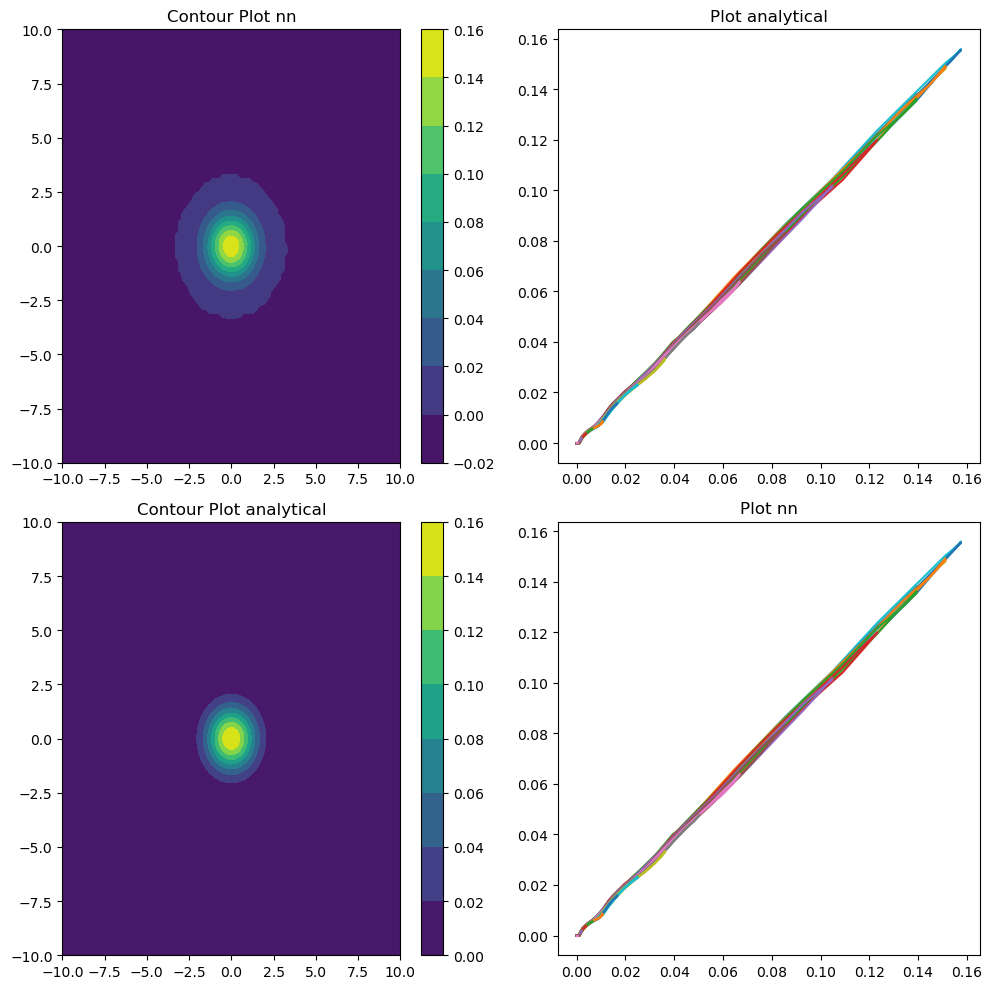

In [240]:
# Generate model predictions
with torch.no_grad():
    model.eval()
    predictions = model(test_data)

# Reshape predictions to match the shape of Z and Z.T
predictions = predictions.view(100, 100, 2)

# Extract the first and second channels of predictions
t0 = predictions[:, :, 0].numpy()
t1 = predictions[:, :, 1].numpy()

# Calculate the Gaussian values
Z1 = np.exp(-(t0**2 + t1**2) / (2 * cov[0][0])) / (2 * np.pi * np.sqrt(cov[0][0]))

# Stack the channels together and reshape to match the shape of Z and Z.T
tr = np.stack((t0, t1), axis=-1).reshape(100, 100, 2)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot the first contour plot
contour1 = axs[0,0].contourf(X, Y, t1, cmap='viridis')
fig.colorbar(contour1, ax=axs[0,0])
axs[0,0].set_title('Contour Plot nn')

# Plot the second contour plot
contour2 = axs[1,0].contourf(X, Y, Z, cmap='viridis')
fig.colorbar(contour2, ax=axs[1,0])
axs[1,0].set_title('Contour Plot analytical')

# Plot the third plot
plot = axs[0,1].plot(Z, t0)
axs[0,1].set_title('Plot analytical')

# Plot the fourth plot
plot = axs[1,1].plot(Z, t1)
axs[1,1].set_title('Plot nn')

plt.tight_layout()
plt.show()

# with physics loss


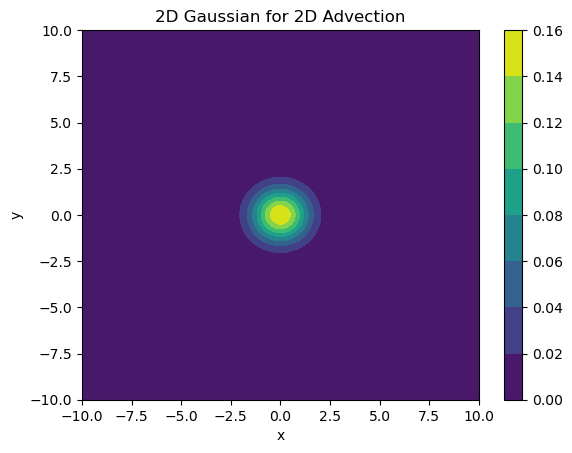

10000
Epoch: 10/10, Loss: 0.08777143806219101


In [241]:


# Define the parameters
mean = [0, 1]
cov = [[1, 0], [0, 1]]
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)

# randomly sample points in x-y space
Xp, Yp = np.random.multivariate_normal(mean, cov, 10).T

train_data_phys = torch.from_numpy(np.vstack((Xp, Yp)).T).float().requires_grad_(True)

# Calculate the Gaussian values
Z = np.exp(-(X**2 + Y**2) / (2 * cov[0][0])) / (2 * np.pi * np.sqrt(cov[0][0]))

# Plot the Gaussian
plt.contourf(X, Y, Z, cmap='viridis')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('2D Gaussian for 2D Advection')
plt.show()
# Generate random 2D Gaussian data for testing
# Convert numpy arrays to PyTorch tensors
train_data = torch.from_numpy(np.vstack((X.flatten(), Y.flatten())).T).float()
train_labels = torch.from_numpy(np.vstack((Z.flatten(), Z.flatten())).T).float()
test_labels = torch.from_numpy(np.vstack((Z.flatten(), Z.flatten())).T).float()
test_data = torch.from_numpy(np.vstack((X.flatten(), Y.flatten())).T).float()
Z = torch.from_numpy(Z.flatten()).float()
# Define the neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Create an instance of the neural network
model = NeuralNetwork()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train the neural network
num_epochs = 10
batch_size = 64

print(train_data.size()[0])

for epoch in range(num_epochs):
    permutation = torch.randperm(train_data.size()[0])
    for i in range(0, train_data.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        
        batch_data, batch_labels = train_data[indices], test_labels[indices]
        #batch_data_phys = train_data_phys[indices]
        optimizer.zero_grad()
        outputs = model(batch_data)
        outputs_phys = model(train_data_phys)
        loss = torch.mean((outputs-batch_labels)**2)
        # Calculate the physics loss
        Z_gradients = torch.autograd.grad(outputs=outputs_phys, inputs=train_data_phys, grad_outputs=torch.ones_like(outputs_phys), create_graph=True)[0]
        physics_loss = torch.mean(Z_gradients)
        
        # Add the physics loss to the total loss
        total_loss = loss + physics_loss
        
        total_loss.backward()
        
        optimizer.step()
        
    if (epoch+1) % 10 == 0:
        print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item()}')


In [243]:
# Define the parameters
mean = [0, 0]
cov = [[2, 0], [1, 1]]
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)

# Calculate the Gaussian values
Z = np.exp(-(X**2 + Y**2) / (2 * cov[0][0])) / (2 * np.pi * np.sqrt(cov[0][0]))
print(Z.shape)
test_data = torch.from_numpy(np.vstack((X.flatten(), Y.flatten())).T).float()

(100, 100)


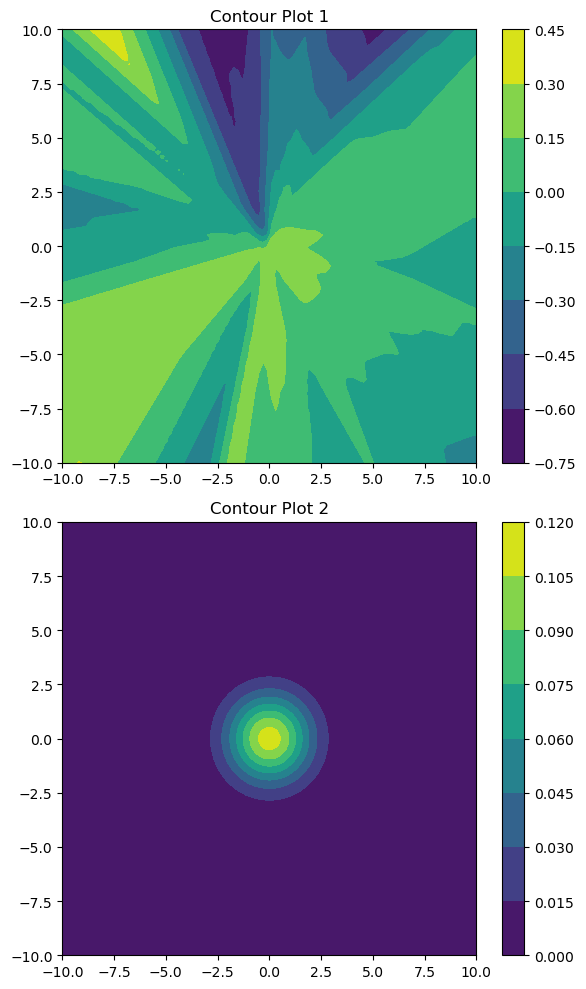

In [248]:
# Generate model predictions
with torch.no_grad():
    model.eval()
    predictions = model(test_data)

# Reshape predictions to match the shape of Z and Z.T
predictions = predictions.view(100, 100, 2)

# Extract the first and second channels of predictions
t0 = predictions[:, :, 0].numpy()
t1 = predictions[:, :, 1].numpy()

# Calculate the Gaussian values
Z1 = np.exp(-(t0**2 + t1**2) / (2 * cov[0][0])) / (2 * np.pi * np.sqrt(cov[0][0]))

# Stack the channels together and reshape to match the shape of Z and Z.T
tr = np.stack((t0, t1), axis=-1).reshape(100, 100, 2)

fig, axs = plt.subplots(2, 1, figsize=(6, 10))

# Plot the first contour plot
contour1 = axs[0].contourf(X, Y, t0, cmap='viridis')
fig.colorbar(contour1, ax=axs[0])
axs[0].set_title('Contour Plot 1')

# Plot the second contour plot
contour2 = axs[1].contourf(X, Y, Z, cmap='viridis')
fig.colorbar(contour2, ax=axs[1])
axs[1].set_title('Contour Plot 2')

plt.tight_layout()
plt.show()